# Install requirements

In [2]:
! pip install pandas
! pip install transformers datasets evaluate rouge_score
! pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121


## Import requirements

In [199]:
import pandas as pd
import csv
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


# Load dataset

In [261]:
df = pd.read_csv('booksummaries.csv', delimiter='\t' , names=["Path", "Title", "Author","Date", "Info", "Text"])

Check missing values

In [262]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16559 entries, 620 to 37159503
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Path    16559 non-null  object
 1   Title   16559 non-null  object
 2   Author  14177 non-null  object
 3   Date    10949 non-null  object
 4   Info    12841 non-null  object
 5   Text    16559 non-null  object
dtypes: object(6)
memory usage: 905.6+ KB


# Clean Data

### Our project primarily relies on the 'Text' column, which is free from NaN values. To maintain data completeness, any missing values in other columns are replaced with designated values rather than being removed.

In [269]:
df.head()

,Path,Title,Author,Date,Info,Text
620,/m/0hhy,Animal Farm,George Orwell,1945,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca..."
843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,-1,{},The argument of the Enquiry proceeds by a ser...
2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,-1,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...


In [264]:
df['Author'] = df['Author'].fillna("unknown")
df['Date'] = df['Date'].apply(lambda x: int(x[:4]) if isinstance(x, str) and x[:4].isdigit() else -1)
df['Info'] = df['Info'].fillna("{}")


In [265]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16559 entries, 620 to 37159503
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Path    16559 non-null  object
 1   Title   16559 non-null  object
 2   Author  16559 non-null  object
 3   Date    16559 non-null  int64 
 4   Info    16559 non-null  object
 5   Text    16559 non-null  object
dtypes: int64(1), object(5)
memory usage: 905.6+ KB


## Explore the dataset's genre distribution. Show the top 10 most frequent genres visually.


In [266]:
genres = {}
info = df.Info.to_list()
for i in range(len(info)):
    tmp = json.loads(info[i])
    for _, value in tmp.items():
        if value in genres:
            genres[value] += 1
        else:
            genres[value] = 1



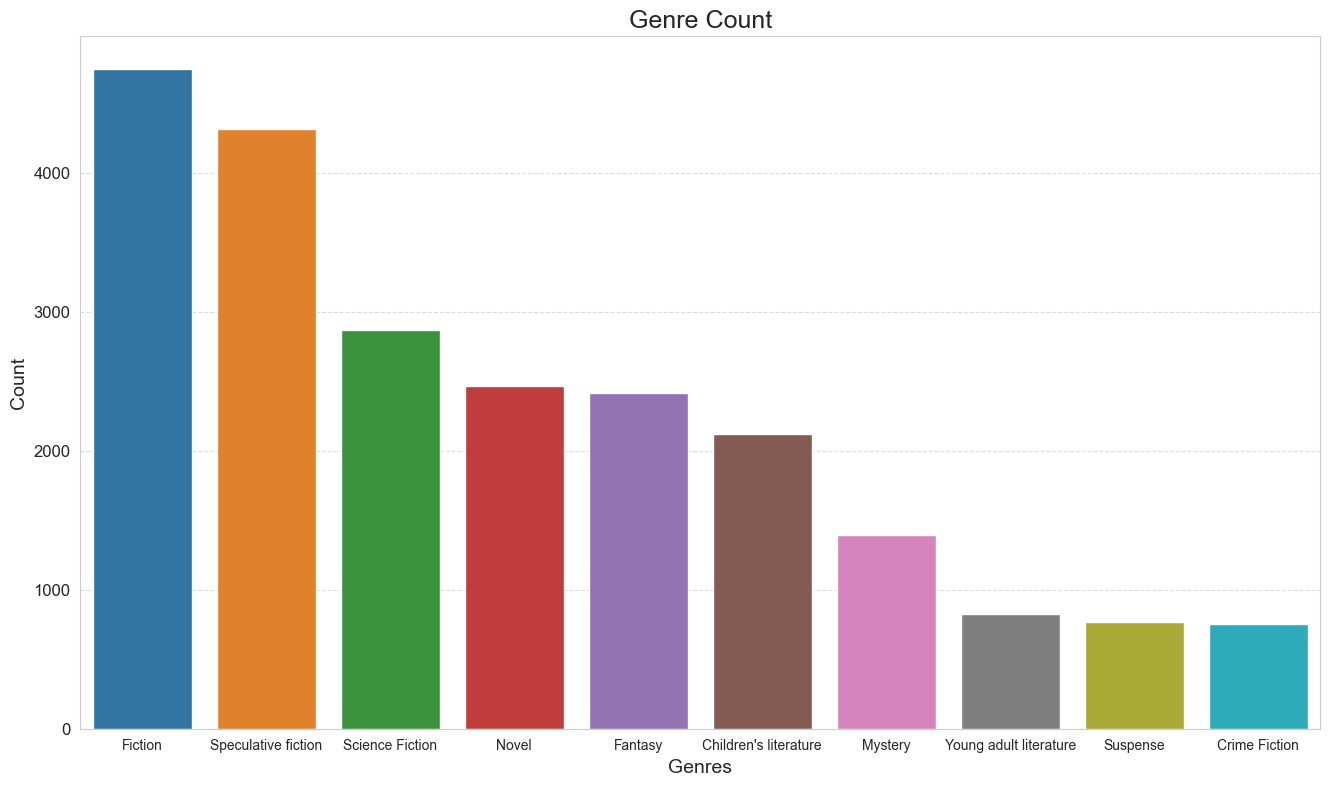

In [267]:
sorted_genres = dict(sorted(genres.items(), key=lambda x: x[1], reverse=True))
top_10_genres = dict(list(sorted_genres.items())[:10])

plt.figure(figsize=(16, 9))

palette = sns.color_palette("tab10")

sns.barplot(x=list(top_10_genres.keys()), y=list(top_10_genres.values()), palette=palette)


plt.title('Genre Count', fontsize=18)
plt.xlabel('Genres', fontsize=14)
plt.ylabel('Count', fontsize=14)

plt.xticks(fontsize=10)
plt.yticks(fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

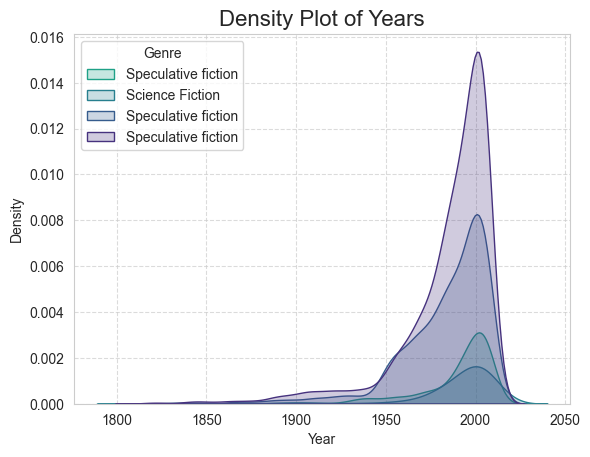

In [320]:
year = df[df['Date'] > 1800]['Date'].tolist()
genre = df[df['Date'] > 1800]['Info'].tolist()
years = []
genras = []
for i in range(len(genre)):
    tmp = json.loads(genre[i])
    for _, value in tmp.items():
        if value in ['Science Fiction', 'Crime Fiction', 'Speculative fiction', 'Horror']:
            years.append(year[i])
            genras.append(value)






sns.set_style("whitegrid")
sns.set_palette("viridis")

sns.kdeplot(x=years , hue = genras, shade=True)




plt.xlabel('Year')
plt.ylabel('Density')
plt.title('Density Plot of Years')
plt.legend(genras, loc='upper left', title="Genre")
plt.title('Density Plot of Years', fontsize=16)

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()


In [9]:
import torch
from transformers import pipeline

summarizer = pipeline(
    "summarization",
    "pszemraj/long-t5-tglobal-base-16384-book-summary",
    device=0 if torch.cuda.is_available() else -1,
)

long_text = "Here is a lot of text I don't want to read. Replace me"

result = summarizer(long_text)
print(result[0]["summary_text"])

Your max_length is set to 512, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)
c:\Users\Keyhan\miniconda3\Lib\site-packages\transformers\modeling_utils.py:1005: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


This is a very long list of text I do not want to read, replace me with you. Replace me.


In [17]:
# Create an empty list to store the summaries
summaries = []

# Use tqdm to iterate over the rows of the DataFrame
for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing rows"):
    # Apply summarization function to the 'Text' column of each row
    summary = summarizer(row["Text"])
    summaries.append(summary)
    if (index) % 5 == 0:
        torch.cuda.empty_cache()


# Add the summaries to the DataFrame
df['summary'] = summaries

# Display the first 5 rows of the DataFrame
df.head(5)


Processing rows:   0%|          | 0/14646 [00:00<?, ?it/s]c:\Users\Keyhan\miniconda3\Lib\site-packages\transformers\modeling_utils.py:1005: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
Processing rows: 100%|██████████| 14646/14646 [16:01:47<00:00,  3.94s/it]
C:\Users\Keyhan\AppData\Local\Temp\ipykernel_58044\3196074791.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['summary'] = summaries


,Path,Title,Author,Date,Info,Text,summary
974786,/m/03vtzm,Dune: The Battle of Corrin,Kevin J. Anderson,2004-08-17,"{""/m/06n90"": ""Science Fiction"", ""/m/014dfn"": ""...",The machine evermind Omnius is continuing wit...,[{'summary_text': 'The narrator tells us that ...
975635,/m/03vxjh,Dandelion Wine,Ray Bradbury,1957,"{""/m/06n90"": ""Science Fiction"", ""/m/05hgj"": ""N...",Chapter 1 — Spending the night in the cupola ...,[{'summary_text': 'Douglas and his brother Tom...
976079,/m/03vz17,Generation Warriors,Anne McCaffrey,1991-03,"{""/m/06n90"": ""Science Fiction"", ""/m/0dwly"": ""C...",The title character from the first book of th...,[{'summary_text': 'The title character of the ...
976105,/m/03vz3t,Volpone,Ben Jonson,1606,{},"Volpone, a Venetian gentleman, pretends to be...",[{'summary_text': 'The narrator describes Volp...
976322,/m/03vzp2,The Chocolate War,Robert Cormier,1974,"{""/m/0dwly"": ""Children's literature"", ""/m/03mf...",Jerry Renault is a self-determined and solita...,[{'summary_text': 'Jerry is a first year stude...


In [22]:
import csv
result_file = open("Summaries.csv",'wb')
with open('output2.csv','w') as result_file:
    wr = csv.writer(result_file, dialect='excel')
    wr.writerows(summaries)

In [215]:

Summaries = pd.read_csv('Summaries.csv' , names=['Summaries'])
Summaries.head(5)


,Summaries
0,{'summary_text': 'Old Major calls the animals ...
1,{'summary_text': 'The narrator introduces us t...
2,"{'summary_text': ""The novel opens with a descr..."
3,{'summary_text': 'Hume begins the book by intr...
4,{'summary_text': 'The novel opens with a descr...


In [216]:
summaries = Summaries['Summaries'].to_list()

In [124]:
# import csv

# # Assuming you have a list named 'text_list' containing the text values

# # Specify the file path where you want to save the CSV file
# csv_file_path = 'Summaries.csv'

# # Open the CSV file in 'w' mode (write mode)
# with open(csv_file_path, 'w', newline='', encoding='utf-8') as csv_file:
#     # Create a CSV writer object
#     csv_writer = csv.writer(csv_file)
    
#     # Write each string from the text_list to the CSV file
#     for text in a1:
#         csv_writer.writerow([text])

# print("CSV file saved successfully!")

In [217]:
for i in range(len(summaries)):
    summaries[i] = json.loads(summaries[i]
                              .replace('\\', '')
                              .replace('"', '\\"')
                              .replace('{\'summary_text\': \'', '{"summary_text": "')
                              .replace('{\'summary_text\': \\"', '{"summary_text": "')
                              .replace('{\\"summary_text\\": \\"', '{"summary_text": "')
                              .replace('\'}', '"}')
                              .replace('\\\"}', '"}')
                              )['summary_text']
    # Summaries[i] = Summaries[i].replace('summary_text:', '')



In [218]:
df['Summaries'] = summaries
df.head(5)

,Path,Title,Author,Date,Info,Text,Summaries
620,/m/0hhy,Animal Farm,George Orwell,1000,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca...",Old Major calls the animals at the farm for an...
843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan...",The narrator introduces us to the protagonist ...
986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...,The novel opens with a description of Oran: th...
1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,1000,{},The argument of the Enquiry proceeds by a ser...,Hume begins the book by introducing his philos...
2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,1000,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...,The novel opens with a description of the five...


# Text-to-Image 

In [212]:
from diffusers import StableDiffusionPipeline
import torch

model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

prompt = "a photo of an astronaut riding a horse on mars"
image = pipe(prompt).images[0]  
    
image.save("astronaut_rides_horse.png")

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [214]:
prompt = "George Winterbourne is a young artist who enlisted in the army during World War I and writes a poem about the war."
image = pipe(prompt).images[0]  

image.save("test.png")

  0%|          | 0/50 [00:00<?, ?it/s]